# Applying Deep Learning Techniques to Predict Muons Momenta

<br> In the following notebook, we will apply several **Deep Learning approaches** to properly **predict muon momentum**. We will use Monte-Carlo simulated data from the Cathode Strip Chambers (CSC) at the CMS experiment. These chambers detect muon particles in the outer layer of the CMS detector, allowing us to store information about the hit locations.
The dataset contains more than 3 million muon events generated using Pythia.

## Importing Libraries
Let's import the libraries that we will need in this project:
First, let's import the libraries that we will need for this project: <br>
- [Numpy](https://numpy.org/doc/) - for vectors manipulation and operations 
- [Scikit-Learn](https://scikit-learn.org/stable/) - for building and training predictive models
- [Matplotlib](https://matplotlib.org/) and [Seaborn](https://seaborn.pydata.org/) - for visualizing various types of plots
- [Pandas](https://pandas.pydata.org/docs/getting_started/overview.html) - for data cleaning and analysis



In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

np.random.seed(48) # set the random seed for reproducible results

For training Neural Networks, we will be using [Tensorflow 2](https://www.tensorflow.org/) which is a famous Deep Learning library used for developing, training and deploying deep learning models. 
<br>
Let's import Tensorflow and check its version:

In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.0


## Retrieving the Dataset


It seems our data is in NPZ format, therefore will use **numpy.load()**
 to load the data files:

In [5]:
data=np.load("histos_tba.npz")

The data file contain two arrays: **variables** and **parameters**. <br>


In [6]:
data["variables"].shape,data["parameters"].shape

((3272341, 87), (3272341, 3))

We will extract the data from the **variabes** array  for the muon hits detected at the CSC chambers only:

In [7]:
def delete_not_csc(data):
  muon_hits=data['variables']
  indices_to_del=[]
  for i in range(muon_hits.shape[1]):
    if(i%12>=5 and i<84):
      indices_to_del.append(i) 
  return np.delete(muon_hits,indices_to_del,axis=1)

muon_hits=delete_not_csc(data)
muon_hits.shape

(3272341, 38)

Next, let's prepare the columns names for each feature and combine the two datasets into a Pandas DataFrame for easier analysis:

In [8]:
original_columns_names=["Phi angle","Theta angle","Bend angle","Time",	"Ring",
               "Front/Rear","Mask"]
columns_names=[]
for element in enumerate(original_columns_names):
  for i in range(5):
    columns_names.append(str(element[1])+str(i))

columns_names.append("XRoad0")
columns_names.append("XRoad1")
columns_names.append("XRoad2")

muon_hits_df=pd.DataFrame(muon_hits,columns=columns_names)
muon_hits_df["q/pt"]=data["parameters"][:,0]
muon_hits_df["Phi_angle"]=data["parameters"][:,1]
muon_hits_df["Eta_angle"]=data["parameters"][:,2]

## Exploratory Data Analysis (EDA)

Let's start our EDA by taking a look at the columns types: 

In [9]:
muon_hits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3272341 entries, 0 to 3272340
Data columns (total 41 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Phi angle0    float32
 1   Phi angle1    float32
 2   Phi angle2    float32
 3   Phi angle3    float32
 4   Phi angle4    float32
 5   Theta angle0  float32
 6   Theta angle1  float32
 7   Theta angle2  float32
 8   Theta angle3  float32
 9   Theta angle4  float32
 10  Bend angle0   float32
 11  Bend angle1   float32
 12  Bend angle2   float32
 13  Bend angle3   float32
 14  Bend angle4   float32
 15  Time0         float32
 16  Time1         float32
 17  Time2         float32
 18  Time3         float32
 19  Time4         float32
 20  Ring0         float32
 21  Ring1         float32
 22  Ring2         float32
 23  Ring3         float32
 24  Ring4         float32
 25  Front/Rear0   float32
 26  Front/Rear1   float32
 27  Front/Rear2   float32
 28  Front/Rear3   float32
 29  Front/Rear4   float32
 30  Mask0         floa

We notice that all our variables have float data type, which we will prove helpful later on when preprocessing the data. 

Next, let's generate some useful statistics about our features:

In [10]:
muon_hits_df.describe()

,Phi angle0,Phi angle1,Phi angle2,Phi angle3,Phi angle4,Theta angle0,Theta angle1,Theta angle2,Theta angle3,Theta angle4,Bend angle0,Bend angle1,Bend angle2,Bend angle3,Bend angle4,Time0,Time1,Time2,Time3,Time4,Ring0,Ring1,Ring2,Ring3,Ring4,Front/Rear0,Front/Rear1,Front/Rear2,Front/Rear3,Front/Rear4,Mask0,Mask1,Mask2,Mask3,Mask4,XRoad0,XRoad1,XRoad2,q/pt,Phi_angle,Eta_angle
count,2.300975e+06,870666.000000,2.789617e+06,2.605933e+06,2.439864e+06,2.300975e+06,870666.000000,2.789617e+06,2.605933e+06,2.439864e+06,2.300975e+06,870666.000000,2.789617e+06,2.605933e+06,2.439864e+06,2.300975e+06,870666.000000,2.789617e+06,2.605933e+06,2.439864e+06,2.300975e+06,870666.0,2.789617e+06,2.605933e+06,2.439864e+06,2.300975e+06,870666.000000,2.789617e+06,2.605933e+06,2.439864e+06,3.272341e+06,3.272341e+06,3.272341e+06,3.272341e+06,3.272341e+06,3.272341e+06,3.272341e+06,3.272341e+06,3.272341e+06,3.272341e+06,3.272341e+06
mean,2.898916e+03,2942.738281,2.884543e+03,2.895544e+03,2.901002e+03,2.513442e+01,62.888813,3.345796e+01,3.376106e+01,3.479657e+01,1.771088e-02,-0.075262,2.404990e-03,7.820615e-04,1.634517e-03,-1.554471e-02,-0.029150,-2.238408e-02,-2.388741e-02,-1.674315e-02,2.208553e+00,2.0,1.234539e+00,1.328101e+00,1.416067e+00,4.993205e-01,0.465420,5.033727e-01,4.964771e-01,5.009226e-01,2.968413e-01,7.339318e-01,1.475164e-01,2.036487e-01,2.543980e-01,3.977467e+00,2.312063e+00,9.032854e+01,-1.427713e-04,-4.566138e-04,-1.287372e-03
std,1.063501e+03,1061.839233,1.087773e+03,1.087355e+03,1.084414e+03,1.279694e+01,10.498766,2.147677e+01,2.178618e+01,2.156608e+01,1.678599e+01,19.846676,3.044079e-01,3.709632e-01,3.650869e-01,1.228342e-01,0.167572,1.469481e-01,1.515253e-01,1.274973e-01,1.475620e+00,0.0,4.290860e-01,4.634236e-01,4.966435e-01,5.000001e-01,0.499028,4.999973e-01,4.999975e-01,5.000001e-01,4.557488e-01,4.387615e-01,3.566231e-01,3.976815e-01,4.353520e-01,1.956127e+00,1.881727e+00,3.388365e+01,2.625431e-01,1.811694e+00,1.889245e+00
min,6.620000e+02,690.000000,9.600000e+01,9.400000e+01,9.600000e+01,5.000000e+00,46.000000,5.000000e+00,5.000000e+00,6.000000e+00,-1.329103e+02,-81.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.000000e+00,2.0,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,-4.999985e-01,-3.141591e+00,-2.499856e+00
25%,2.005000e+03,2032.000000,1.980000e+03,1.998000e+03,2.000000e+03,1.400000e+01,54.000000,1.600000e+01,1.600000e+01,1.600000e+01,-1.200000e+01,-14.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.0,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,6.200000e+01,-2.194096e-01,-1.571401e+00,-1.880253e+00
50%,2.891000e+03,2937.000000,2.882000e+03,2.896000e+03,2.904000e+03,2.300000e+01,62.000000,2.800000e+01,2.800000e+01,2.900000e+01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.0,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,2.000000e+00,9.000000e+01,-4.459424e-04,7.330791e-04,-1.202088e+00
75%,3.792000e+03,3853.000000,3.791000e+03,3.795000e+03,3.800000e+03,3.500000e+01,71.000000,4.700000e+01,5.200000e+01,5.200000e+01,1.200000e+01,14.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,2.0,1.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00,4.000000e+00,1.190000e+02,2.191571e-01,1.56

We notice that some features such as **Phi angle1**, **Theta angle1** and **Bend angle1** have some missing values. <br> Let's find the exact percentage of null values for each feature:


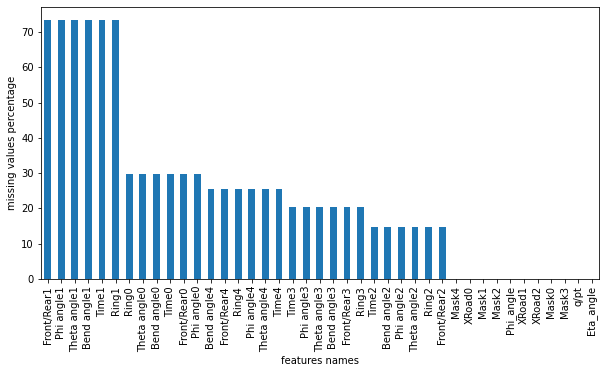

In [11]:
null_perc=((muon_hits_df.isnull().
           sum()/muon_hits_df.
           shape[0]
           )*100).sort_values(ascending=False)

fig = plt.figure(figsize = (10,5))
ax = fig.gca()
ax.set_xlabel("features names")
ax.set_ylabel("missing values percentage")

null_perc.plot.bar(ax=ax)
plt.show()

We notice that **Front/Rear1**, **Phi angle1**, **Theta angle1**, **Bend angle1**, **Time1** and **Ring1** features have more than 70% missing values!<br> 
Next, let's take a look on the data distribution of each feature:



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


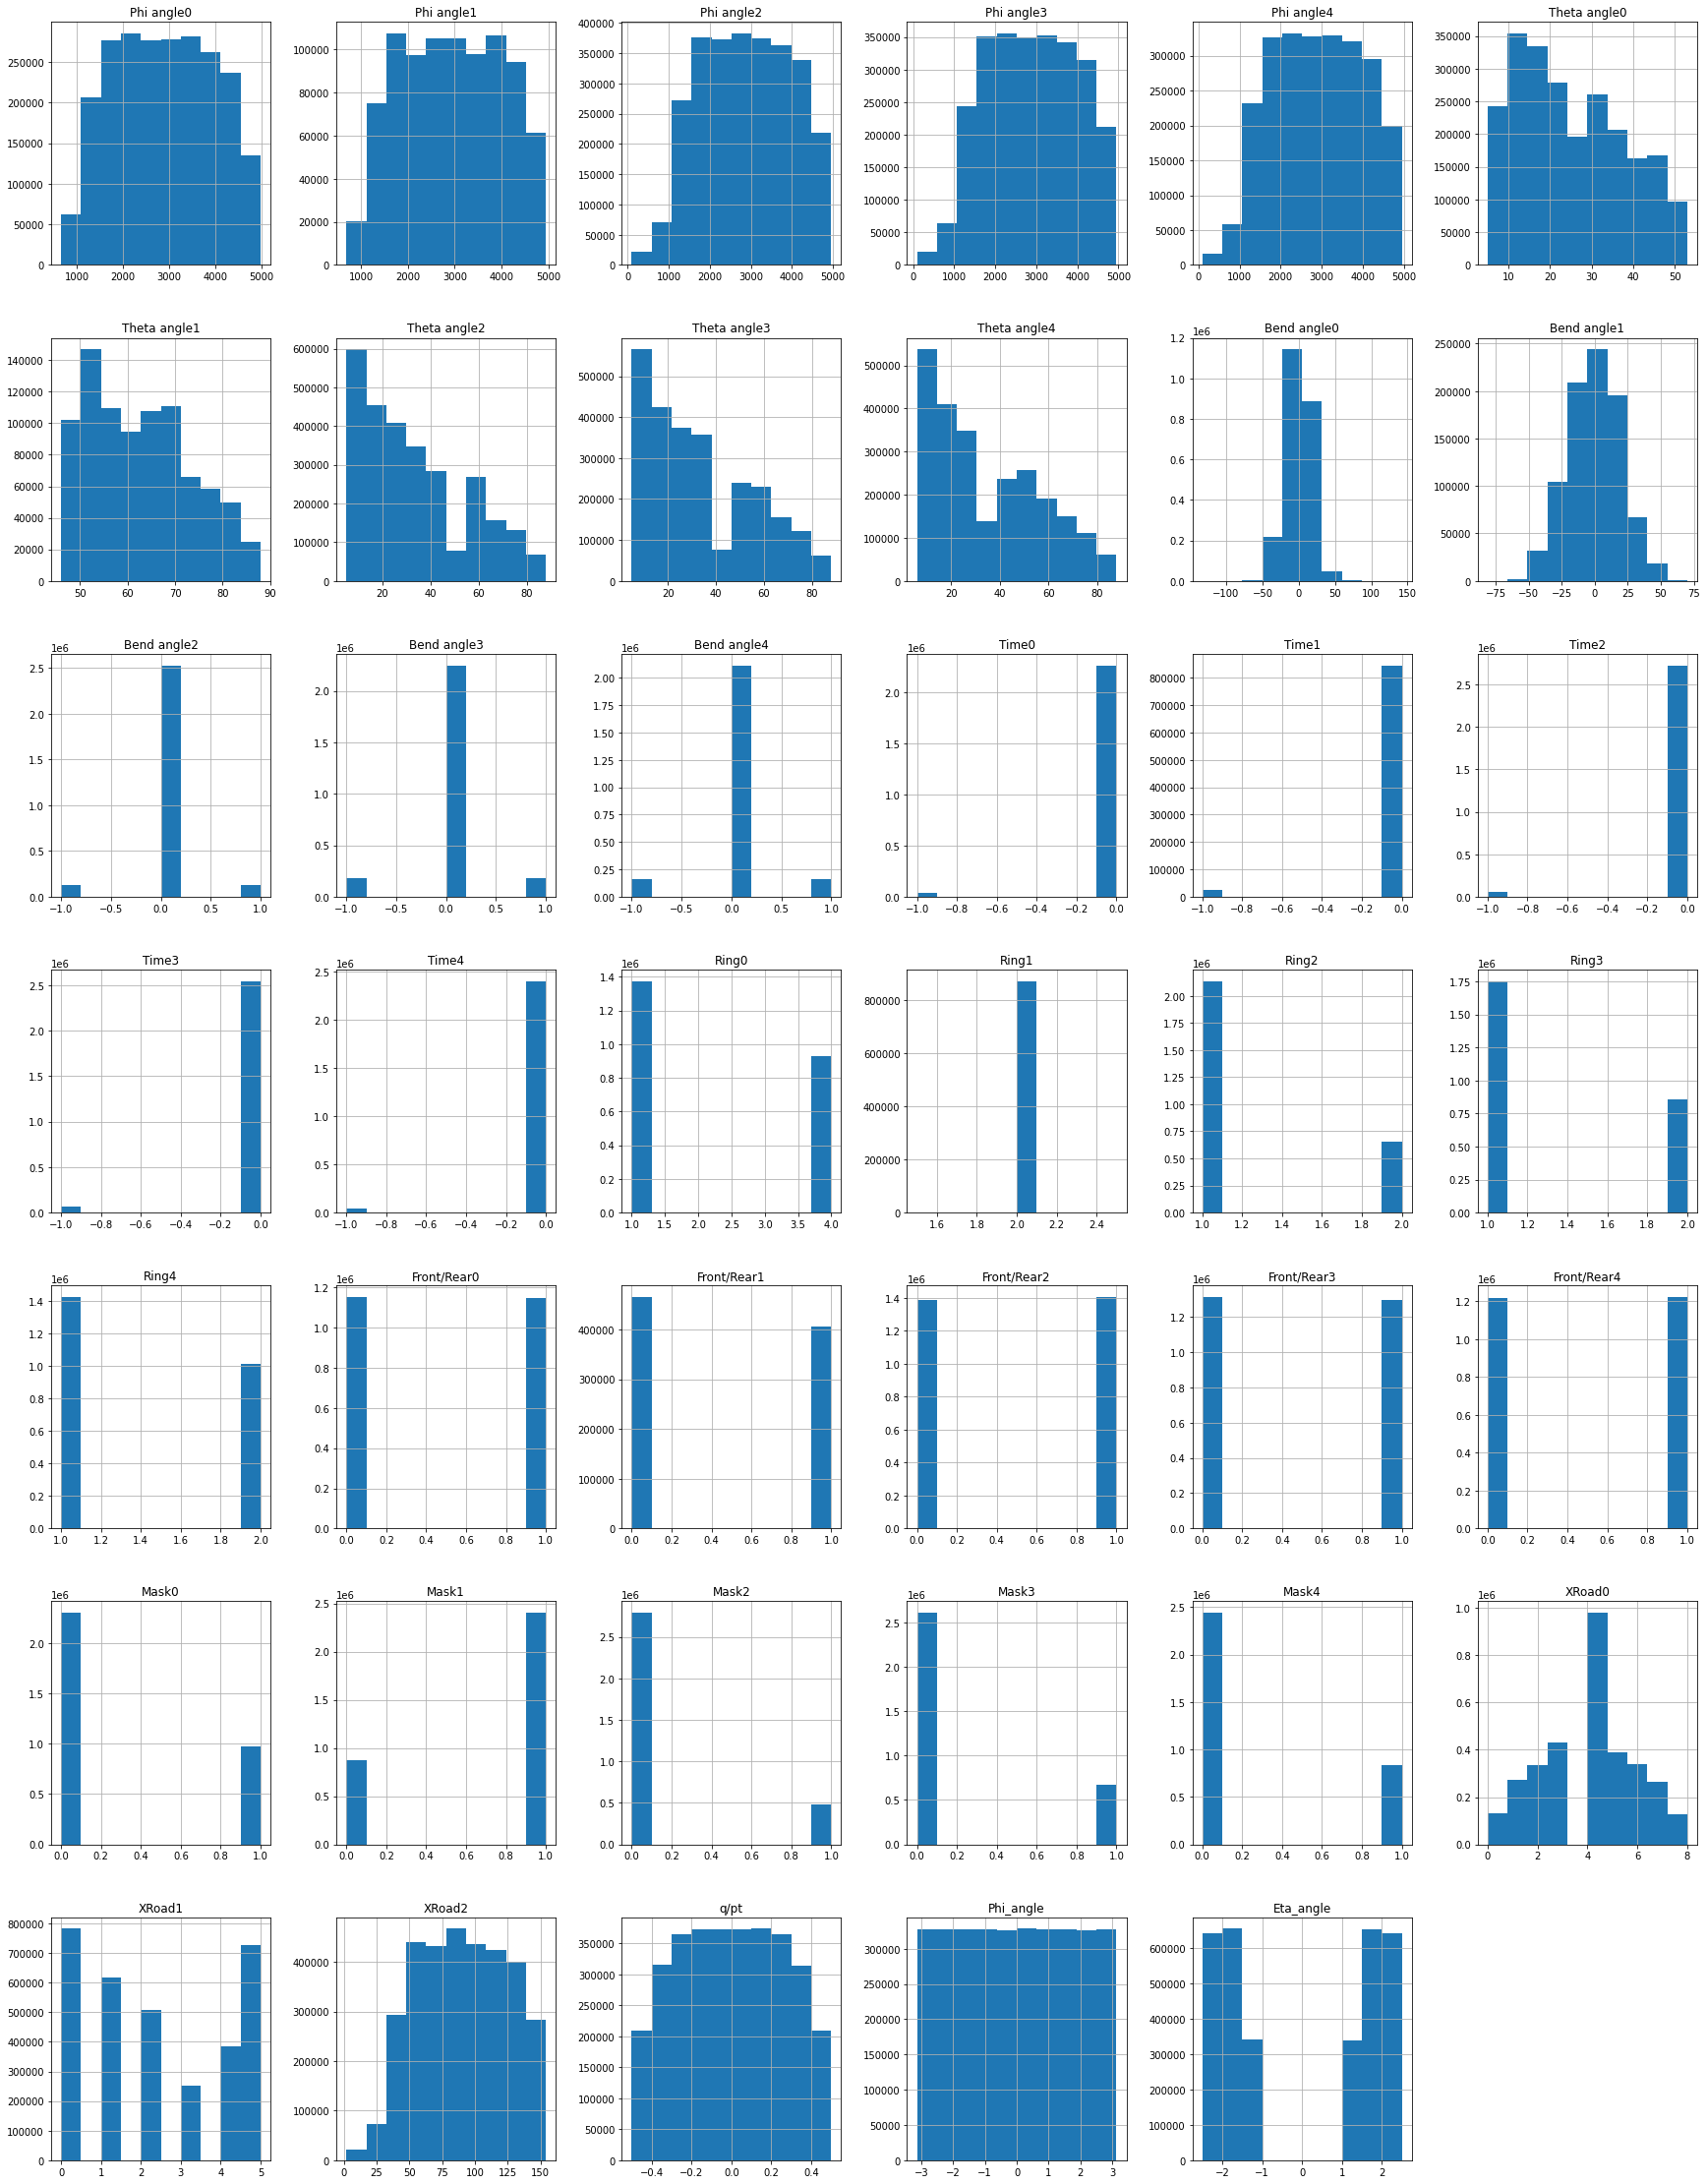

In [12]:
fig = plt.figure(figsize = (30,40))
ax = fig.gca()
muon_hits_df.hist(ax=ax)
plt.show()

Wow, those are a LOT of plots! It is clear from these plots that some features such as **Theta Angle1**,**Theta Angle2**, **Theta Angle3** and **XRoad1** can benefit from being transformed into Normal Distribution (Standardization).

Next, let's investigate the effect of each feature on the target feature **q/pt**:

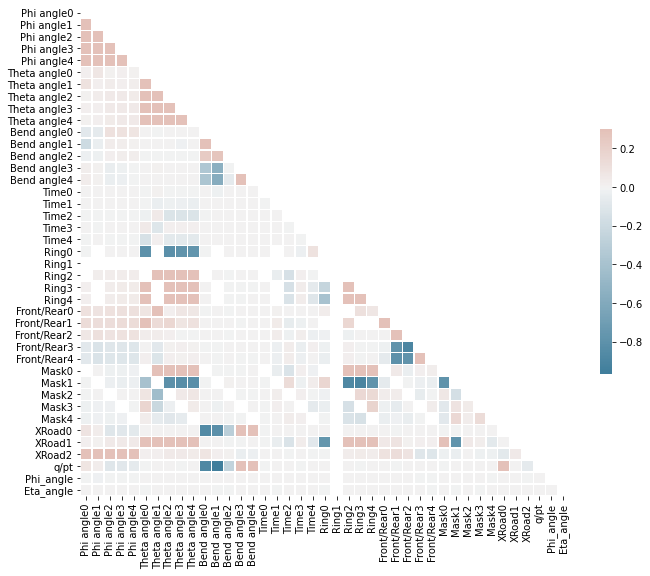

In [13]:
corr=muon_hits_df.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Framing the Problem as a Classification Task
Instead of trying to apply regression to predict the muon momenta values (**q/pt**), let's try to cluster the momenta into 4 classes: **0-10 GeV, 10-30 GeV, 30-100 GeV and >100 GeV**, and instead frame the problem as a classification task.

Let's investigate the q/pt column and separate it from the data: 

In [14]:
pt_inverse_labels=muon_hits_df["q/pt"]
muon_hits_df_x=muon_hits_df.drop("q/pt",axis=1)
muon_hits_df["q/pt"].describe()

count    3.272341e+06
mean    -1.427713e-04
std      2.625431e-01
min     -4.999985e-01
25%     -2.194096e-01
50%     -4.459424e-04
75%      2.191571e-01
max      4.999996e-01
Name: q/pt, dtype: float64

We will use **the absolute value of the reciprocal of the target feature (pt/q)** to group the momenta into the previously mentioned classes:

In [15]:
pt_labels=abs((1/pt_inverse_labels))
pt_labels.describe()

count    3.272341e+06
mean     1.859705e+01
std      1.257423e+02
min      2.000001e+00
25%      2.998728e+00
50%      4.560210e+00
75%      9.115835e+00
max      6.989345e+03
Name: q/pt, dtype: float64

Let's visualize the data distribution of this feature:

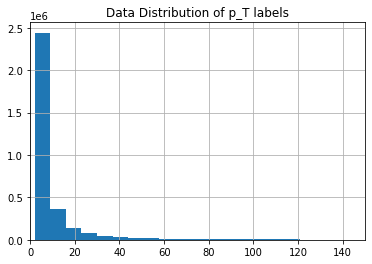

In [16]:
pt_labels.hist(bins=1000)
plt.xlim([0,150])
plt.title("Data Distribution of p_T labels")
plt.show()

That is a very interesting plot! We can clearly see that there are distinct groups of points of different magnitudes.<br>
We can now **group the values into 4 groups**: 0-10 GeV, 10-30 GeV, 30-100 GeV and >100 GeV using the **cut method from Pandas**.

In [17]:
bins = pd.IntervalIndex.from_tuples([(0, 10), (10, 30), (30, 100),(100,pt_labels.max()+1)])
org_pt_labels_groups=pd.cut(pt_labels, bins)

Let's plot the grouped data now:

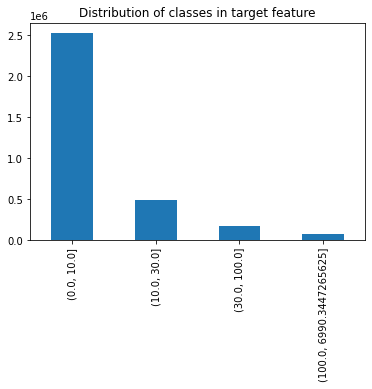

In [18]:
target_counts=org_pt_labels_groups.value_counts()
target_counts.plot.bar()
plt.title("Distribution of classes in target feature")
plt.show()

It is very clear that the **classes are not balanced**, therefore it is important to **balance those classes** whenever we start training our Neural Network to **avoid any bias**.

### Splitting the Data
Next, let's seperate the data into train and test data, we will use a 90%-10% split.

As we already noticed, the data is highly imbalanced, therefore it is important to perform the following two tasks:
- **Add class weights to balance out the classes**
- **Make the test set representative of the classes**

To split the train and test data,
we will use the **StratifiedShuffleSplit method** in Scikit-Learn to make both the train data and test data representative of the target classes distribution:

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(muon_hits_df_x, org_pt_labels_groups):
    muon_hits_x_train_set = muon_hits_df_x.loc[train_index]
    pt_labels_groups_y_train_set=org_pt_labels_groups[train_index]
    muon_hits_x_test_set = muon_hits_df_x.loc[test_index]
    pt_labels_groups_y_test_set=org_pt_labels_groups[test_index]

Let's verify if the data has the same proportions for the target label in the train and test sets:

In [20]:
def target_proportions(data):
  return data.value_counts()/len(data)*100

proportions_df=pd.DataFrame({"Original": target_proportions(org_pt_labels_groups),
"Train":target_proportions(pt_labels_groups_y_train_set),
"Test":target_proportions(pt_labels_groups_y_test_set)},
)

proportions_df

,Original,Train,Test
"(0.0, 10.0]",77.201062,77.201058,77.201094
"(10.0, 30.0]",15.207951,15.207942,15.208031
"(30.0, 100.0]",5.331871,5.331862,5.331948
"(100.0, 6990.3447265625]",2.259117,2.259138,2.258927


Neat! Now that we are sure that the train and test data are representative of the original dataset, we can now proceed to the preprocessing phase. 

### Preparing data for training
As we noticed earlier, we need delete the columns with percentage of missing values bigger than 70%:

In [21]:
def delete_columns(df,perc):
  null_perc=(df.isnull().sum()/df.shape[0])*100
  col_to_del= [col for col in df.columns if(((null_perc)>perc)[col])]
  print("columns deleted:", col_to_del)
  return df.drop(col_to_del,axis=1)

muon_hits_x_train_set_1=delete_columns(muon_hits_x_train_set,70)

columns deleted: ['Phi angle1', 'Theta angle1', 'Bend angle1', 'Time1', 'Ring1', 'Front/Rear1']


In [22]:
muon_hits_x_train_set_1.shape

(2945106, 34)

For all other features with percentage of null values less than 70%, we will replace the null values with the mean value of their corresponding columns:

In [23]:
def replace_missing_with_mean(df):
  from sklearn.impute import SimpleImputer 
  imputer = SimpleImputer(missing_values=np.nan, strategy='mean')  
  imputed=imputer.fit_transform(df)
  return pd.DataFrame(imputed,columns=df.columns)

In [24]:
muon_hits_x_train_set_2=replace_missing_with_mean(muon_hits_x_train_set_1)

In [25]:
null_perc_2=(muon_hits_x_train_set_2.isnull().
             sum()/muon_hits_x_train_set_2.
             shape[0])*100
null_perc_2.sort_values(ascending=False)

Eta_angle       0.0
Bend angle0     0.0
Time3           0.0
Time2           0.0
Time0           0.0
Bend angle4     0.0
Bend angle3     0.0
Bend angle2     0.0
Theta angle4    0.0
Phi_angle       0.0
Theta angle3    0.0
Theta angle2    0.0
Theta angle0    0.0
Phi angle4      0.0
Phi angle3      0.0
Phi angle2      0.0
Time4           0.0
Ring0           0.0
Ring2           0.0
Ring3           0.0
Ring4           0.0
Front/Rear0     0.0
Front/Rear2     0.0
Front/Rear3     0.0
Front/Rear4     0.0
Mask0           0.0
Mask1           0.0
Mask2           0.0
Mask3           0.0
Mask4           0.0
XRoad0          0.0
XRoad1          0.0
XRoad2          0.0
Phi angle0      0.0
dtype: float64

Now we are sure that we filled all missing values.

Let's next create the preprocessing pipeline and convert the target feature into one hot encoded variables.

In [26]:
def preprocess_pipeline(df_x,df_y):
  #delete columns with missing values more than 70%
  df_x=delete_columns(df_x,70)

  #impute the other columns with missing values with their corresponding means 
  df_x=replace_missing_with_mean(df_x)

  #standardize the data
  from sklearn.preprocessing import StandardScaler
  scaler=StandardScaler()
  x=scaler.fit_transform(df_x)

  #convert labels into dummy variables (one hot encoded)
  from sklearn.preprocessing import LabelEncoder
  encoder = LabelEncoder()
  encoded_y = encoder.fit_transform(df_y)
  print(encoder.classes_)

  from sklearn.preprocessing import OneHotEncoder
  ohe=OneHotEncoder(sparse=False)
  ohe_y=ohe.fit_transform(encoded_y.reshape(-1,1))
  print(ohe.categories_)

  return x,ohe_y,encoded_y

In [27]:
muon_hits_x_train_values,pt_labels_ohe_y_train,y_encoded_train=preprocess_pipeline(muon_hits_x_train_set,pt_labels_groups_y_train_set)

columns deleted: ['Phi angle1', 'Theta angle1', 'Bend angle1', 'Time1', 'Ring1', 'Front/Rear1']
[Interval(0.0, 10.0, closed='right') Interval(10.0, 30.0, closed='right')
 Interval(30.0, 100.0, closed='right')
 Interval(100.0, 6990.3447265625, closed='right')]
[array([0, 1, 2, 3])]


In [28]:
muon_hits_x_test_values,pt_labels_ohe_y_test,y_encoded_test=preprocess_pipeline(muon_hits_x_test_set,pt_labels_groups_y_test_set)

columns deleted: ['Phi angle1', 'Theta angle1', 'Bend angle1', 'Time1', 'Ring1', 'Front/Rear1']
[Interval(0.0, 10.0, closed='right') Interval(10.0, 30.0, closed='right')
 Interval(30.0, 100.0, closed='right')
 Interval(100.0, 6990.3447265625, closed='right')]
[array([0, 1, 2, 3])]


Now our datasets are ready for training and testing! 
<br> One last task to do before training, which is generating the classes weights:

In [29]:
#option 1
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_encoded_train),
                                                  y_encoded_train)


In [30]:
class_weights

array([ 0.32382976,  1.64387796,  4.68879315, 11.06616918])

In [31]:
#option 2
class_weights=len(y_encoded_train)/(4*(np.unique(y_encoded_train,return_counts=True)[1]))
classes_weights={i: class_weights[i] for i in range(len(class_weights))}
classes_weights

{0: 0.3238297576631087,
 1: 1.6438779611065217,
 2: 4.688793152857116,
 3: 11.066169176661557}

### Building the Neural Network
We will use Tensorflow's Keras library to build the Neural Network


### Building a Fully Connected Neural Network
Let's first build and compile the model:

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout
model=Sequential()
model.add(Dense(512,input_dim=(muon_hits_x_train_values.shape[1]),activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(4,activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


Let's take a closer look at the model architecture:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               17920     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2

Next, we will set some callbacks for the model including a **Checkpoint callback** and **Early Stopping callback** that both monitor the model's **validation accuracy**:

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

filepath="classifier_weights2-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
checkpoint2= EarlyStopping( monitor='val_accuracy', patience=3)

callbacks_list = [checkpoint1,checkpoint1]

Now we can finally start training! 
<br>We will use a **25% validation split**, **batch size of 500** and will **train for 100 epochs**. 

In [ ]:
history = model.fit(muon_hits_x_train_values,  pt_labels_ohe_y_train, 
                    validation_split=0.25, 
                    epochs=200, 
                    batch_size=500,
                    callbacks=callbacks_list,
                    class_weight=classes_weights)

Epoch 1/200
4417/4418 [============================>.] - ETA: 0s - loss: 0.9673 - accuracy: 0.7593
Epoch 00001: val_accuracy improved from -inf to 0.76394, saving model to classifier_weights2-improvement-01-0.76.hdf5

Epoch 00001: val_accuracy did not improve from 0.76394
4418/4418 [==============================] - 91s 21ms/step - loss: 0.9673 - accuracy: 0.7593 - val_loss: 0.5584 - val_accuracy: 0.7639
Epoch 2/200
4417/4418 [============================>.] - ETA: 0s - loss: 0.9354 - accuracy: 0.7702
Epoch 00002: val_accuracy improved from 0.76394 to 0.77115, saving model to classifier_weights2-improvement-02-0.77.hdf5

Epoch 00002: val_accuracy did not improve from 0.77115
4418/4418 [==============================] - 91s 21ms/step - loss: 0.9354 - accuracy: 0.7702 - val_loss: 0.5633 - val_accuracy: 0.7711
Epoch 3/200
4418/4418 [==============================] - ETA: 0s - loss: 0.9298 - accuracy: 0.7716
Epoch 00003: val_accuracy improved from 0.77115 to 0.77407, saving model to classi

Next, let's plot the evolution of the metrics over the epochs of training:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


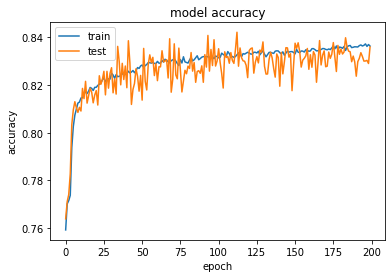

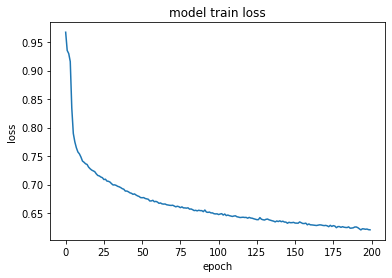

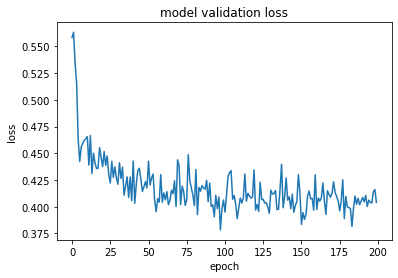

In [ ]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("accuracy2.png")
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig("loss2-1.png")
plt.show()

plt.plot(history.history['val_loss'])
plt.title('model validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig("loss2-2.png")
plt.show()


Let's load the model with the best performance:

In [ ]:
model.load_weights("/content/classifier_weights-improvement-94-0.84.hdf5")

### Testing the Model
We will examine the accuracy of the model on the train set and the test set: 
<br> Let's generate a classification report that will give us insights on the performance of the model on both train set and test set:

In [ ]:
from sklearn.metrics import classification_report
y_train_pred=model.predict(muon_hits_x_train_values)
y_train_pred_best=np.argmax(y_train_pred,axis=1)
train_report=classification_report(y_encoded_train,y_train_pred_best)

In [ ]:
y_test_pred=model.predict(muon_hits_x_test_values)
y_test_pred_best=np.argmax(y_test_pred,axis=1)
test_report=classification_report(y_encoded_test,y_test_pred_best)

In [ ]:
print("Train report \n",train_report)
print("Test report \n",test_report)

Train report 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94   2273653
           1       0.65      0.59      0.62    447890
           2       0.33      0.73      0.46    157029
           3       0.36      0.66      0.47     66534

    accuracy                           0.84   2945106
   macro avg       0.58      0.72      0.62   2945106
weighted avg       0.89      0.84      0.86   2945106

Test report 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94    252629
           1       0.64      0.58      0.61     49766
           2       0.32      0.70      0.44     17448
           3       0.33      0.61      0.43      7392

    accuracy                           0.84    327235
   macro avg       0.57      0.70      0.61    327235
weighted avg       0.89      0.84      0.85    327235



That's impressive! It seems that adding class weights definitely reduced bias and we reached a weighted f1-score of 0.85 on the test data!

# Experimenting with Regression 
Instead of classifying into four group, let us try to directly predict the q/pT value for each muon momentum: 


## Splitting the Data
Let us first split the dataset into train and test data:

In [32]:
from sklearn.model_selection import train_test_split
muon_hits_x_train,muon_hits_x_test,pt_inverse_labels_train, pt_inverse_labels_test = train_test_split(muon_hits_df_x,pt_inverse_labels,test_size=0.1, random_state=42)

Next, let's create the pipeline for preprocessing the data for regression:

In [33]:
def preprocess_pipeline_reg(df_x,df_y):
  #delete columns with missing values more than 70%
  df_x=delete_columns(df_x,70)

  #impute the other columns with missing values with their corresponding means 
  df_x=replace_missing_with_mean(df_x)

  #standardize the data
  from sklearn.preprocessing import StandardScaler
  scaler=StandardScaler()
  x=scaler.fit_transform(df_x)

  return x,df_y.values

In [34]:
muon_hits_x_train_values,pt_inverse_labels_train_values=preprocess_pipeline_reg(muon_hits_x_train, pt_inverse_labels_train)
muon_hits_x_test_values,pt_inverse_labels_test_values=preprocess_pipeline_reg(muon_hits_x_test, pt_inverse_labels_test)

columns deleted: ['Phi angle1', 'Theta angle1', 'Bend angle1', 'Time1', 'Ring1', 'Front/Rear1']
columns deleted: ['Phi angle1', 'Theta angle1', 'Bend angle1', 'Time1', 'Ring1', 'Front/Rear1']


## Building the Model
Let's first build and compile the model:

In [39]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout
reg_model=Sequential()
reg_model.add(Dense(512,input_dim=(muon_hits_x_train_values.shape[1]),activation='relu'))
reg_model.add(Dense(256,activation='relu'))
reg_model.add(Dropout(0.1))
reg_model.add(Dense(128,activation='relu'))
reg_model.add(Dense(64,activation='relu'))
reg_model.add(Dropout(0.1))
reg_model.add(Dense(32,activation='relu'))
reg_model.add(Dropout(0.1))
reg_model.add(Dense(1,activation='linear'))

reg_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss='mean_squared_error')


In [36]:
reg_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               17920     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2

Next, we will set some callbacks for the model including a **Checkpoint callback** and **Early Stopping callback** that will both monitor the model's **validation mean square error**:

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

filepath="reg_weights2-improvement-{epoch:02d}-{val_loss:.6f}.hdf5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint2= EarlyStopping( monitor='val_loss', patience=3)

callbacks_list = [checkpoint1,checkpoint1]

In [41]:
reg_history = reg_model.fit(muon_hits_x_train_values, pt_inverse_labels_train_values, validation_split=0.25, epochs=200, batch_size=2000,callbacks=callbacks_list)

Epoch 1/200
1104/1105 [============================>.] - ETA: 0s - loss: 0.0067
Epoch 00001: val_loss improved from inf to 0.00518, saving model to reg_weights2-improvement-01-0.005183.hdf5

Epoch 00001: val_loss did not improve from 0.00518
1105/1105 [==============================] - 56s 51ms/step - loss: 0.0067 - val_loss: 0.0052
Epoch 2/200
1104/1105 [============================>.] - ETA: 0s - loss: 0.0050
Epoch 00002: val_loss improved from 0.00518 to 0.00482, saving model to reg_weights2-improvement-02-0.004817.hdf5

Epoch 00002: val_loss did not improve from 0.00482
1105/1105 [==============================] - 58s 52ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 3/200
1104/1105 [============================>.] - ETA: 0s - loss: 0.0047
Epoch 00003: val_loss improved from 0.00482 to 0.00456, saving model to reg_weights2-improvement-03-0.004556.hdf5

Epoch 00003: val_loss did not improve from 0.00456
1105/1105 [==============================] - 56s 51ms/step - loss: 0.0047 - val_

Next, let's plot the evolution of the model over the epochs of training:

dict_keys(['loss', 'val_loss'])


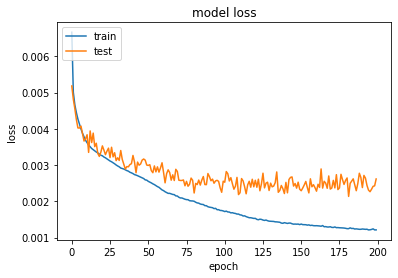

In [42]:
# list all data in history
print(reg_history.history.keys())

# summarize history for loss
plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("reg_loss.png")
plt.show()

## Model Testing
Let's evaluate the model performance over the train and test set:


In [44]:
reg_model.load_weights("/content/reg_weights2-improvement-81-0.002230.hdf5")

In [45]:
from sklearn.metrics import mean_squared_error
y_train_pred_reg=reg_model.predict(muon_hits_x_train_values)
print("train root mean squared error: ",mean_squared_error(pt_inverse_labels_train_values,y_train_pred_reg,squared=False))

y_test_pred_reg=reg_model.predict(muon_hits_x_test_values)
print("test root mean squared error: ",mean_squared_error(pt_inverse_labels_test_values,y_test_pred_reg,squared=False))

train root mean squared error:  0.046178654
test root mean squared error:  0.047247976


That is impressive! the root mean square error on the testing data is relatively small in comparison to the data! 

# Future Directions
- We discovered in this project that the **classifier** model was **not very good in detecting minority classes**. Therefore we need to look for more techniques to **make the model less biased** (such as **up sampling minority classes** or **down sampling the majority class**).
- We can further improve the performance of our regression model by **hyperparameters tuning** through **grid search**. 